<a href="https://colab.research.google.com/github/janahendy30/HealthCare-Provider-Fraud-Detection/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: imports & load
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve)
import matplotlib.pyplot as plt

# Optional: SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load
df = pd.read_csv("/content/provider_features.csv")
df.head()


,Provider,PotentialFraud,Inpatient_BeneID_nunique,Inpatient_ClaimID_count,Inpatient_InscClaimAmtReimbursed_sum,Inpatient_InscClaimAmtReimbursed_mean,Inpatient_InscClaimAmtReimbursed_max,Inpatient_Total_Procedures_sum,Inpatient_Total_Procedures_mean,Inpatient_Total_Procedures_max,...,Bene_ChronicCond_Heartfailure,Bene_ChronicCond_Cancer,Bene_ChronicCond_Diabetes,Bene_ChronicCond_KidneyDisease,Bene_ChronicCond_ObstrPulmonary,Bene_ChronicCond_Depression,Bene_ChronicCond_IschemicHeart,Bene_ChronicCond_Osteoporasis,Bene_ChronicCond_rheumatoidarthritis,Bene_ChronicCond_stroke
0,PRV51001,No,5.0,5.0,97000.0,19400.000000,42000.0,3.0,0.600000,2.0,...,1.250000,1.791667,1.166667,1.291667,1.625000,1.625000,1.083333,1.750000,1.666667,1.791667
1,PRV51003,Yes,53.0,62.0,573000.0,9241.935484,57000.0,48.0,0.774194,2.0,...,1.401709,1.914530,1.256410,1.555556,1.717949,1.598291,1.153846,1.760684,1.726496,1.923077
2,PRV51004,No,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.405797,1.884058,1.304348,1.659420,1.731884,1.565217,1.289855,1.688406,1.702899,1.884058
3,PRV51005,Yes,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.468687,1.880808,1.365657,1.640404,1.787879,1.628283,1.298990,1.713131,1.743434,1.921212
4,PRV51007,No,3.0,3.0,19000.0,6333.333333,10000.0,1.0,0.333333,1.0,...,1.482759,1.896552,1.379310,1.706897,1.793103,1.637931,1.310345,1.706897,1.724138,1.844828


In [2]:
df.columns


Index(['Provider', 'PotentialFraud', 'Inpatient_BeneID_nunique',
       'Inpatient_ClaimID_count', 'Inpatient_InscClaimAmtReimbursed_sum',
       'Inpatient_InscClaimAmtReimbursed_mean',
       'Inpatient_InscClaimAmtReimbursed_max',
       'Inpatient_Total_Procedures_sum', 'Inpatient_Total_Procedures_mean',
       'Inpatient_Total_Procedures_max',
       'Inpatient_AttendingPhysician_nunique',
       'Inpatient_OperatingPhysician_nunique', 'Outpatient_BeneID_nunique',
       'Outpatient_ClaimID_count', 'Outpatient_InscClaimAmtReimbursed_sum',
       'Outpatient_InscClaimAmtReimbursed_mean',
       'Outpatient_InscClaimAmtReimbursed_max',
       'Outpatient_Total_Procedures_sum', 'Outpatient_Total_Procedures_mean',
       'Outpatient_Total_Procedures_max',
       'Outpatient_AttendingPhysician_nunique',
       'Outpatient_OperatingPhysician_nunique', 'Bene_Age',
       'Bene_ChronicCond_Alzheimer', 'Bene_ChronicCond_Heartfailure',
       'Bene_ChronicCond_Cancer', 'Bene_ChronicCond_Dia

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Assuming df is your DataFrame, and 'PotentialFraud' is the target column
target_col = 'PotentialFraud'
x = df.drop(columns=[target_col, 'Provider'])  # Drop target and identifier column
y = df[target_col]  # Define the target variable

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = x.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# Create a pipeline with SMOTE and a classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),  # Oversample the minority class (fraudulent cases)
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Inpatient_BeneID_nunique',
                                                   'Inpatient_ClaimID_count',
                                                   'Inpatient_InscClaimAmtReimbursed_sum',
                                                   'Inpatient_InscClaimAmtReimbursed_mean',
                                                   'Inpatient_InscClaimAmtReimbursed_max',
                                                   'Inpatient_Total...
                                                   'Bene_ChronicCond_Depression',
                                                   'Bene_ChronicCond_IschemicHeart',
                                                   'Bene_ChronicCond_Osteoporasis', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('classifier', RandomForestClassifier(random_state=42))])

In [4]:
print(y.unique())


['No' 'Yes']


In [5]:
# Generate predictions on the test set
y_pred = pipeline.predict(x_test)


In [6]:
# Convert 'Yes' and 'No' to numeric labels (1 for 'Yes', 0 for 'No')
y_test_numeric = pd.Series(y_test).map({'Yes': 1, 'No': 0})
y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})


In [7]:
# Evaluate the model using metrics
precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Precision: {precision}")

recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Recall: {recall}")

f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"F1 Score: {f1}")

# For PR AUC and ROC AUC, ensure to use probabilities for the positive class ('Yes')
y_prob = pipeline.predict_proba(x_test)[:, 1]  # Probabilities for the positive class ('Yes')

pr_auc = average_precision_score(y_test_numeric, y_prob)
print(f"PR AUC: {pr_auc}")

roc_auc = roc_auc_score(y_test_numeric, y_prob)
print(f"ROC AUC: {roc_auc}")


Precision: 0.536
Recall: 0.638095238095238
F1 Score: 0.5826086956521739
PR AUC: 0.6142586592222481
ROC AUC: 0.9147195009016913


In [8]:
# Import additional models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Create pipelines for each model with SMOTE
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

log_reg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', LogisticRegression(random_state=42))
])

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy='minority')),
    ('classifier', SVC(probability=True, random_state=42))
])

# Function to evaluate models using metrics
def evaluate_model(model_pipeline, X_train, y_train, X_test, y_test):
    # Train the model
    model_pipeline.fit(X_train, y_train)

    # Generate predictions
    y_pred = model_pipeline.predict(X_test)

    # Convert y_test and y_pred to numeric format for scoring (Yes=1, No=0)
    y_test_numeric = y_test.map({'Yes': 1, 'No': 0})
    y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})

    # Calculate performance metrics
    precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
    recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
    f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)

    # For PR AUC and ROC AUC, need probabilities for the positive class (fraudulent)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test_numeric, y_prob)
    roc_auc = roc_auc_score(y_test_numeric, y_prob)

    # Print results
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"PR AUC: {pr_auc}")
    print(f"ROC AUC: {roc_auc}")

# Evaluate each model
print("Decision Tree Results:")
evaluate_model(dt_pipeline, x_train, y_train, x_test, y_test)

print("\nLogistic Regression Results:")
evaluate_model(log_reg_pipeline, x_train, y_train, x_test, y_test)

print("\nRandom Forest Results:")
evaluate_model(rf_pipeline, x_train, y_train, x_test, y_test)

print("\nGradient Boosting Results:")
evaluate_model(gb_pipeline, x_train, y_train, x_test, y_test)

print("\nSupport Vector Machine Results:")
evaluate_model(svm_pipeline, x_train, y_train, x_test, y_test)

Decision Tree Results:
Precision: 0.4375
Recall: 0.6
F1 Score: 0.5060240963855421
PR AUC: 0.3013170055452865
ROC AUC: 0.7585465711361311

Logistic Regression Results:
Precision: 0.4473684210526316
Recall: 0.8095238095238095
F1 Score: 0.576271186440678
PR AUC: 0.6852998907683935
ROC AUC: 0.9358190768630892

Random Forest Results:
Precision: 0.5333333333333333
Recall: 0.6095238095238096
F1 Score: 0.5688888888888889
PR AUC: 0.6132542286954353
ROC AUC: 0.916712969732417

Gradient Boosting Results:
Precision: 0.47468354430379744
Recall: 0.7142857142857143
F1 Score: 0.5703422053231939
PR AUC: 0.6364157927414411
ROC AUC: 0.9137398255105523

Support Vector Machine Results:
Precision: 0.4221105527638191
Recall: 0.8
F1 Score: 0.5526315789473685
PR AUC: 0.5238490084028115
ROC AUC: 0.9090510308524637


Precision: 0.536
Recall: 0.638095238095238
F1 Score: 0.5826086956521739
PR AUC: 0.6142586592222481
ROC AUC: 0.9147195009016913


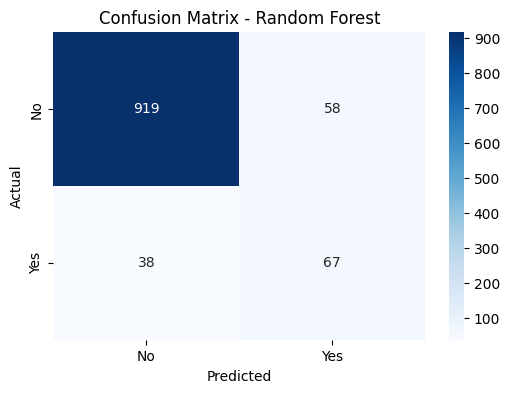

In [9]:
import seaborn as sns

# Convert 'Yes' and 'No' to numeric labels (1 for 'Yes', 0 for 'No')
y_test_numeric = y_test.map({'Yes': 1, 'No': 0})
y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})

# Now calculate the metrics with the converted labels
precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Precision: {precision}")

recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"Recall: {recall}")

f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)
print(f"F1 Score: {f1}")

# For PR AUC and ROC AUC, ensure to use probabilities for the positive class ('Yes')
y_prob = pipeline.predict_proba(x_test)[:, 1]  # Probabilities for the positive class ('Yes')

pr_auc = average_precision_score(y_test_numeric, y_prob)
print(f"PR AUC: {pr_auc}")

roc_auc = roc_auc_score(y_test_numeric, y_prob)
print(f"ROC AUC: {roc_auc}")

# Define model name for the plot
model_name = "Random Forest"

# Optionally, display confusion matrix and plots
cm = confusion_matrix(y_test_numeric, y_pred_numeric)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
# my hypothesis i believe that random forest is the better model

Logistic Regression Results:
Precision: 0.7580645161290323
Recall: 0.44761904761904764
F1 Score: 0.562874251497006
PR AUC: 0.6813123595240579
ROC AUC: 0.9280401618170299


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


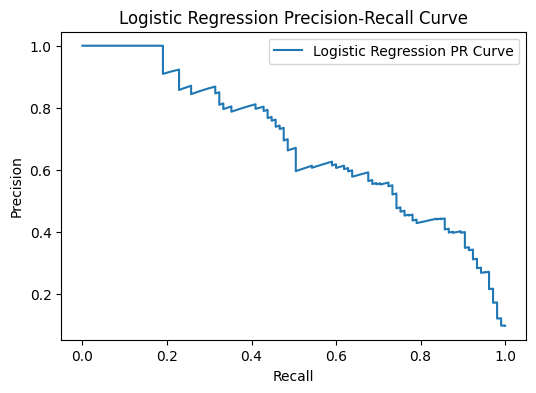

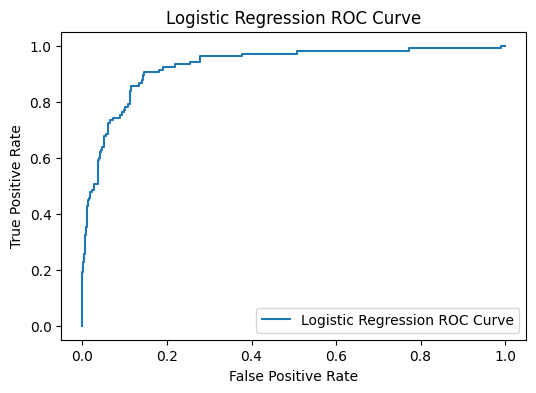

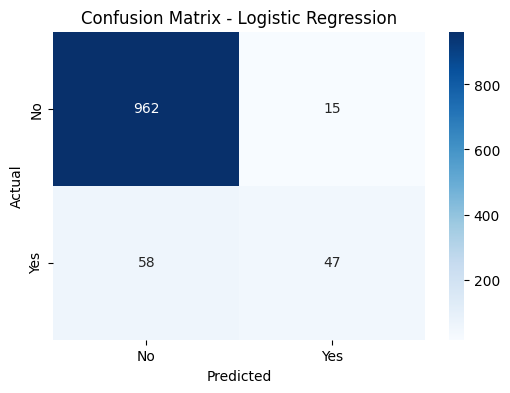

Random Forest Results:
Precision: 0.6935483870967742
Recall: 0.4095238095238095
F1 Score: 0.5149700598802395
PR AUC: 0.6345004473016503
ROC AUC: 0.9204805770824194


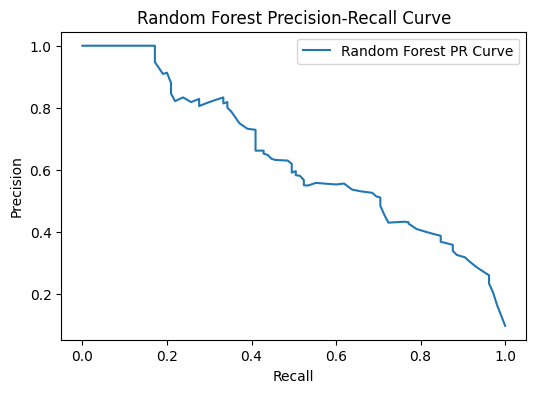

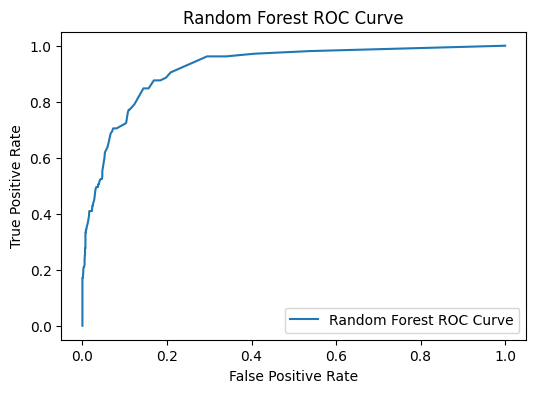

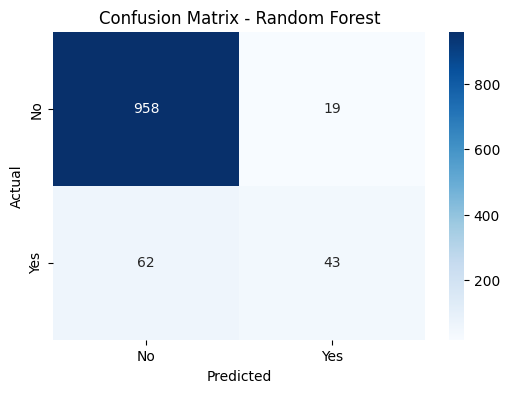

Gradient Boosting Results:
Precision: 0.6507936507936508
Recall: 0.3904761904761905
F1 Score: 0.4880952380952381
PR AUC: 0.650898147949618
ROC AUC: 0.9303406930837842


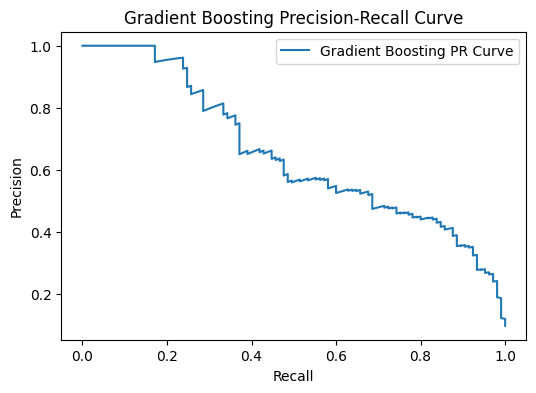

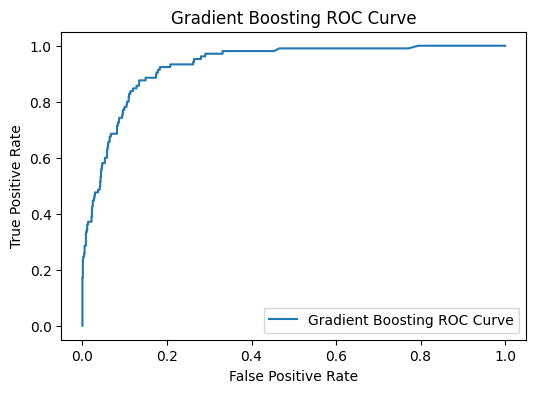

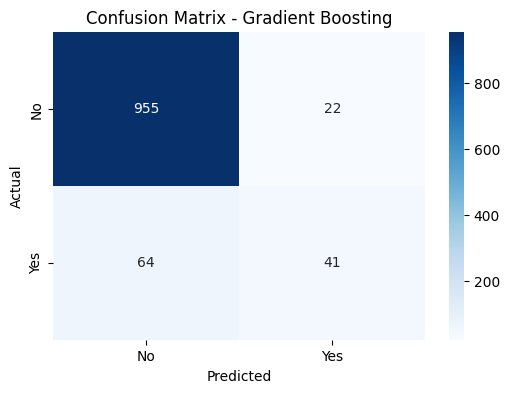

SVM Results:
Precision: 0.7659574468085106
Recall: 0.34285714285714286
F1 Score: 0.47368421052631576
PR AUC: 0.4978297464717576
ROC AUC: 0.6477165277574695


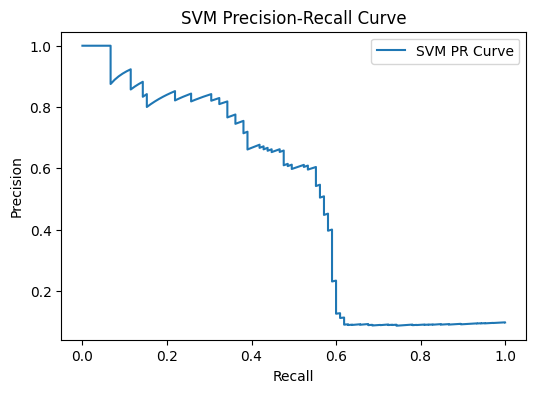

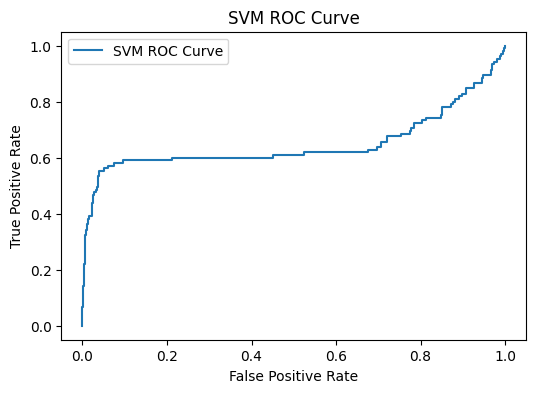

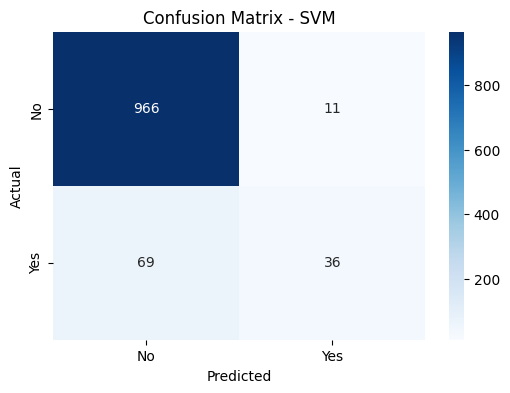

                 Model  Precision    Recall  F1 Score    PR AUC   ROC AUC
0  Logistic Regression   0.758065  0.447619  0.562874  0.681312  0.928040
1        Random Forest   0.693548  0.409524  0.514970  0.634500  0.920481
2    Gradient Boosting   0.650794  0.390476  0.488095  0.650898  0.930341
3                  SVM   0.765957  0.342857  0.473684  0.497830  0.647717


In [11]:
# Define all models for comparison
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True)
}

# Store results for comparison
results = []

# Loop through all models
for model_name, model in models.items():
    print(f"{model_name} Results:")

    # Fit the model
    model.fit(x_train, y_train)

    # Generate predictions on the test set
    y_pred = model.predict(x_test)

    # Convert predictions and true values to numeric
    y_test_numeric = pd.Series(y_test).map({'Yes': 1, 'No': 0})
    y_pred_numeric = pd.Series(y_pred).map({'Yes': 1, 'No': 0})

    # Calculate metrics
    precision = precision_score(y_test_numeric, y_pred_numeric, pos_label=1)
    recall = recall_score(y_test_numeric, y_pred_numeric, pos_label=1)
    f1 = f1_score(y_test_numeric, y_pred_numeric, pos_label=1)
    pr_auc = average_precision_score(y_test_numeric, model.predict_proba(x_test)[:, 1])
    roc_auc = roc_auc_score(y_test_numeric, model.predict_proba(x_test)[:, 1])

    # Store the metrics
    results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'PR AUC': pr_auc,
        'ROC AUC': roc_auc
    })

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"PR AUC: {pr_auc}")
    print(f"ROC AUC: {roc_auc}")

    # Plot Precision-Recall curve
    plt.figure(figsize=(6, 4))
    precision_vals, recall_vals, _ = precision_recall_curve(y_test_numeric, model.predict_proba(x_test)[:, 1])
    plt.plot(recall_vals, precision_vals, label=f'{model_name} PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(6, 4))
    fpr, tpr, _ = roc_curve(y_test_numeric, model.predict_proba(x_test)[:, 1])
    plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test_numeric, y_pred_numeric)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Display model comparison results
comparison_df = pd.DataFrame(results)
print(comparison_df)


In [12]:
#based on the results my hypothesis was wrong since logistic regression has the highest Precision  Recall F1 Score  PR AUC  ROC AUC

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Initialize StratifiedKFold with 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize list to store scores for each fold
cv_scores = []

# Cross-validation loop
for train_index, test_index in kf.split(x, y):
    # Split the data into train and test for this fold
    x_train_cv, x_test_cv = x.iloc[train_index], x.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Preprocessing pipeline
    pipeline.fit(x_train_cv, y_train_cv)

    # Generate predictions for this fold
    y_pred_cv = pipeline.predict(x_test_cv)

    # Calculate accuracy for this fold and append to cv_scores
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    cv_scores.append(accuracy)

# Calculate the average accuracy score across all folds
mean_accuracy = np.mean(cv_scores)
print(f"Average Cross-Validation Accuracy: {mean_accuracy}")


Average Cross-Validation Accuracy: 0.9105360443622921


In [14]:
# Identify False Positives: Actual = 0, Predicted = 1
false_positives_indices = y_test_numeric[(y_test_numeric == 0) & (y_pred_numeric == 1)].index
false_positives_df = df.loc[false_positives_indices].copy()
false_positives_df['Actual'] = y_test_numeric[false_positives_indices]
false_positives_df['Predicted'] = y_pred_numeric[false_positives_indices]

# Identify False Negatives: Actual = 1, Predicted = 0
false_negatives_indices = y_test_numeric[(y_test_numeric == 1) & (y_pred_numeric == 0)].index
false_negatives_df = df.loc[false_negatives_indices].copy()
false_negatives_df['Actual'] = y_test_numeric[false_negatives_indices]
false_negatives_df['Predicted'] = y_pred_numeric[false_negatives_indices]

# Select 2-3 cases for case studies
false_positive_cases = false_positives_df.head(3)
false_negative_cases = false_negatives_df.head(3)

# Print case studies
print("False Positive Cases (Legitimate providers flagged as fraud):")
print(false_positive_cases[['Provider', 'Actual', 'Predicted']])
print("\nFalse Negative Cases (Fraudulent providers missed):")
print(false_negative_cases[['Provider', 'Actual', 'Predicted']])

False Positive Cases (Legitimate providers flagged as fraud):
      Provider  Actual  Predicted
1039  PRV52296       0          1
1057  PRV52318       0          1
346   PRV51438       0          1

False Negative Cases (Fraudulent providers missed):
     Provider  Actual  Predicted
296  PRV51378       1          0
381  PRV51480       1          0
132  PRV51170       1          0


In [15]:
# Assigning cost values for false positives and false negatives
false_positive_cost = 1000
false_negative_cost = 5000

# Calculate the total cost for false positives and false negatives
total_fp_cost = len(false_positive_cases) * false_positive_cost
total_fn_cost = len(false_negative_cases) * false_negative_cost

# Print the total cost for error types
print(f"Total False Positive Cost: ${total_fp_cost}")
print(f"Total False Negative Cost: ${total_fn_cost}")


Total False Positive Cost: $3000
Total False Negative Cost: $15000


In [16]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, None],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and print them
print(f"Best parameters found: {grid_search.best_params_}")

# Evaluate the best model from grid search
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test)

# Convert y_pred_best to numeric labels (1 for 'Yes', 0 for 'No')
y_pred_best_numeric = pd.Series(y_pred_best).map({'Yes': 1, 'No': 0})

# Recalculate metrics with the best model using numeric predictions
precision_best = precision_score(y_test_numeric, y_pred_best_numeric, pos_label=1)
recall_best = recall_score(y_test_numeric, y_pred_best_numeric, pos_label=1)
f1_best = f1_score(y_test_numeric, y_pred_best_numeric, pos_label=1)
roc_auc_best = roc_auc_score(y_test_numeric, y_pred_best_numeric)

print(f"Best Precision: {precision_best}")
print(f"Best Recall: {recall_best}")
print(f"Best F1 Score: {f1_best}")
print(f"Best ROC AUC: {roc_auc_best}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END classifier__max_depth=10, classifier__n_estimators=50; total time=   1.2s
[CV] END classifier__max_depth=10, classifier__n_estimators=50; total time=   1.2s
[CV] END classifier__max_depth=10, classifier__n_estimators=50; total time=   2.2s
[CV] END classifier__max_depth=10, classifier__n_estimators=50; total time=   2.2s
[CV] END classifier__max_depth=10, classifier__n_estimators=50; total time=   1.2s
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time=   2.8s
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time=   2.3s
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time=   2.4s
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time=   2.4s
[CV] END classifier__max_depth=10, classifier__n_estimators=200; total time=   5.4s
[CV] END classifier__

In [17]:
# Fit the Logistic Regression model
log_reg_pipeline.fit(x_train, y_train)

# Generate predictions
y_pred_log_reg = log_reg_pipeline.predict(x_test)

# Convert y_pred_log_reg to numeric labels (1 for 'Yes', 0 for 'No')
y_pred_log_reg_numeric = pd.Series(y_pred_log_reg).map({'Yes': 1, 'No': 0})

# Evaluate the model
precision_log_reg = precision_score(y_test_numeric, y_pred_log_reg_numeric, pos_label=1)
recall_log_reg = recall_score(y_test_numeric, y_pred_log_reg_numeric, pos_label=1)
f1_log_reg = f1_score(y_test_numeric, y_pred_log_reg_numeric, pos_label=1)
y_prob_log_reg = log_reg_pipeline.predict_proba(x_test)[:, 1]
pr_auc_log_reg = average_precision_score(y_test_numeric, y_prob_log_reg)
roc_auc_log_reg = roc_auc_score(y_test_numeric, y_prob_log_reg)

# Print results for Logistic Regression
print(f"Logistic Regression - Precision: {precision_log_reg}")
print(f"Logistic Regression - Recall: {recall_log_reg}")
print(f"Logistic Regression - F1 Score: {f1_log_reg}")
print(f"Logistic Regression - PR AUC: {pr_auc_log_reg}")
print(f"Logistic Regression - ROC AUC: {roc_auc_log_reg}")


Logistic Regression - Precision: 0.4627659574468085
Logistic Regression - Recall: 0.8285714285714286
Logistic Regression - F1 Score: 0.5938566552901023
Logistic Regression - PR AUC: 0.6865594375510617
Logistic Regression - ROC AUC: 0.9374177511332066


In [18]:
# Fit the Gradient Boosting model
gb_pipeline.fit(x_train, y_train)

# Generate predictions
y_pred_gb = gb_pipeline.predict(x_test)

# Convert y_pred_gb to numeric labels (1 for 'Yes', 0 for 'No')
y_pred_gb_numeric = pd.Series(y_pred_gb).map({'Yes': 1, 'No': 0})

# Evaluate the model
precision_gb = precision_score(y_test_numeric, y_pred_gb_numeric, pos_label=1)
recall_gb = recall_score(y_test_numeric, y_pred_gb_numeric, pos_label=1)
f1_gb = f1_score(y_test_numeric, y_pred_gb_numeric, pos_label=1)
y_prob_gb = gb_pipeline.predict_proba(x_test)[:, 1]
pr_auc_gb = average_precision_score(y_test_numeric, y_prob_gb)
roc_auc_gb = roc_auc_score(y_test_numeric, y_prob_gb)

# Print results for Gradient Boosting
print(f"Gradient Boosting - Precision: {precision_gb}")
print(f"Gradient Boosting - Recall: {recall_gb}")
print(f"Gradient Boosting - F1 Score: {f1_gb}")
print(f"Gradient Boosting - PR AUC: {pr_auc_gb}")
print(f"Gradient Boosting - ROC AUC: {roc_auc_gb}")

Gradient Boosting - Precision: 0.48148148148148145
Gradient Boosting - Recall: 0.7428571428571429
Gradient Boosting - F1 Score: 0.5842696629213483
Gradient Boosting - PR AUC: 0.6392386026899043
Gradient Boosting - ROC AUC: 0.9161963249987816


In [19]:
# Fit the Random Forest model
rf_pipeline.fit(x_train, y_train)

# Generate predictions
y_pred_rf = rf_pipeline.predict(x_test)

# Convert y_pred_rf to numeric labels (1 for 'Yes', 0 for 'No')
y_pred_rf_numeric = pd.Series(y_pred_rf).map({'Yes': 1, 'No': 0})

# Evaluate the model
precision_rf = precision_score(y_test_numeric, y_pred_rf_numeric, pos_label=1)
recall_rf = recall_score(y_test_numeric, y_pred_rf_numeric, pos_label=1)
f1_rf = f1_score(y_test_numeric, y_pred_rf_numeric, pos_label=1)
y_prob_rf = rf_pipeline.predict_proba(x_test)[:, 1]
pr_auc_rf = average_precision_score(y_test_numeric, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test_numeric, y_prob_rf)

# Print results for Random Forest
print(f"Random Forest - Precision: {precision_rf}")
print(f"Random Forest - Recall: {recall_rf}")
print(f"Random Forest - F1 Score: {f1_rf}")
print(f"Random Forest - PR AUC: {pr_auc_rf}")
print(f"Random Forest - ROC AUC: {roc_auc_rf}")

Random Forest - Precision: 0.5508474576271186
Random Forest - Recall: 0.6190476190476191
Random Forest - F1 Score: 0.5829596412556054
Random Forest - PR AUC: 0.5988822621824236
Random Forest - ROC AUC: 0.9159672466734903


In [20]:
import pandas as pd

# Store the results for each model in a list of dictionaries
results = [
    {"Model": "Logistic Regression", "Precision": precision_log_reg, "Recall": recall_log_reg, "F1 Score": f1_log_reg, "PR AUC": pr_auc_log_reg, "ROC AUC": roc_auc_log_reg},
    {"Model": "Gradient Boosting", "Precision": precision_gb, "Recall": recall_gb, "F1 Score": f1_gb, "PR AUC": pr_auc_gb, "ROC AUC": roc_auc_gb},
    {"Model": "Random Forest", "Precision": precision_rf, "Recall": recall_rf, "F1 Score": f1_rf, "PR AUC": pr_auc_rf, "ROC AUC": roc_auc_rf}
]

# Convert results to a DataFrame for easy visualization
comparison_df = pd.DataFrame(results)

# Display the comparison table
print(comparison_df)


                 Model  Precision    Recall  F1 Score    PR AUC   ROC AUC
0  Logistic Regression   0.462766  0.828571  0.593857  0.686559  0.937418
1    Gradient Boosting   0.481481  0.742857  0.584270  0.639239  0.916196
2        Random Forest   0.550847  0.619048  0.582960  0.598882  0.915967


In [21]:
# Print the false positive and false negative cases for analysis
print("False Positive Cases (Legitimate providers flagged as fraud):")
print(false_positive_cases[['Provider', 'Actual', 'Predicted']])

print("\nFalse Negative Cases (Fraudulent providers missed):")
print(false_negative_cases[['Provider', 'Actual', 'Predicted']])

# Analyze why the model made these errors:
# Let's look at the features for the false positive and false negative cases
false_positive_features = x_test.loc[false_positive_cases.index]
false_negative_features = x_test.loc[false_negative_cases.index]

# Display the features for false positives and false negatives
print("\nFeatures for False Positive Cases:")
print(false_positive_features)

print("\nFeatures for False Negative Cases:")
print(false_negative_features)

# You can investigate if certain features appear more frequently among false positives or false negatives,
# which might provide insights into model performance.


False Positive Cases (Legitimate providers flagged as fraud):
      Provider  Actual  Predicted
1039  PRV52296       0          1
1057  PRV52318       0          1
346   PRV51438       0          1

False Negative Cases (Fraudulent providers missed):
     Provider  Actual  Predicted
296  PRV51378       1          0
381  PRV51480       1          0
132  PRV51170       1          0

Features for False Positive Cases:
      Inpatient_BeneID_nunique  Inpatient_ClaimID_count  \
1039                       2.0                      2.0   
1057                       0.0                      0.0   
346                        2.0                      2.0   

      Inpatient_InscClaimAmtReimbursed_sum  \
1039                               12000.0   
1057                                   0.0   
346                                15000.0   

      Inpatient_InscClaimAmtReimbursed_mean  \
1039                                 6000.0   
1057                                    0.0   
346               